In [1]:
import numpy as np
from numpy.fft import rfft, rfftfreq
from scipy.sparse import spdiags
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnchoredText
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees,degrees2kilometers
import time
import scipy
from scipy import interpolate
import math
import glob
import os
import obspy

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import sys
sys.path.append('/home/yaolinm/Projects/Mexico2/')
from funcs.bp import *
from funcs.mccc import *
from funcs.utils import *

import imageio
import pandas as pd

from numba import njit
import numba
import copy

# Seismometers

In [2]:
eq=earthquake(-103.269,18.2377,25.5)
sub1=earthquake(-103.55,18.55,25.5)
sub2=earthquake(-104,18.85,25.5)
sub3=earthquake(-104.4,19.15,25.5)
longitude_range=[-104.5,-102.5]
latitude_range=[17.5,19.5]
grid=gridize(longitude_range,latitude_range,stepsize=0.02)
x_mesh,y_mesh=grid.mesh()

df = pd.read_csv('data/stations_data.csv')
longitudes = df["Longitude"].tolist()
latitudes = df["Latitude"].tolist()
azimuths = df["Azimuth"].tolist()

global_rtable=reference_table(model='iasp91',eq=eq,wave='P')
corners=[[latitude_range[0],longitude_range[0]],[latitude_range[0],longitude_range[1]],[latitude_range[1],longitude_range[0]],[latitude_range[1],longitude_range[1]]]
degrees=[]
for corner in corners:
    for i in range(len(longitudes)):
        degrees.append(locations2degrees(latitudes[i],longitudes[i],corner[0],corner[1]))
        
global_rtable.cal_table(np.min(degrees)-0.5,np.max(degrees)+0.5,0.05)

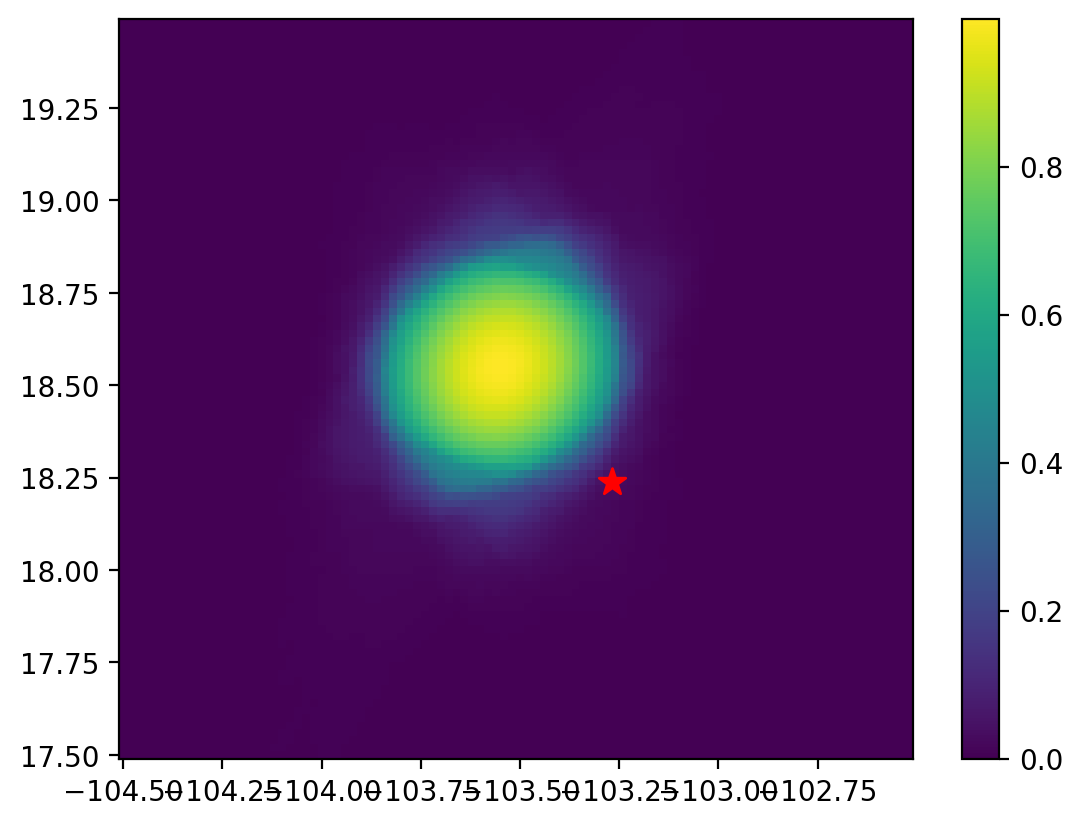

In [3]:
global_sensors=[]    
for i in range(len(latitudes)):
    global_sensor=sensor(longitudes[i],latitudes[i],trace_len=1200,sampling=20,eq_start=20)
    global_sensor.cal_epitime(eq,global_rtable)
    global_sensor.cal_epitime(sub1,global_rtable,etype='subevent')
    global_sensor.cal_epitime(sub2,global_rtable,etype='subevent')
    global_sensor.cal_epitime(sub3,global_rtable,etype='subevent')
    global_sensor.calculate_ttime(grid,global_rtable)
    tr=ricker_taup(60,global_sensor.sampling,0.1,1,20+1+global_sensor.subevents[0]-global_sensor.epitime)[0]
#     tr+=ricker_taup(120,global_sensor.sampling,0.1,0.8,20+8+global_sensor.subevents[1]-global_sensor.epitime)[0]
#     tr+=ricker_taup(120,global_sensor.sampling,0.1,0.6,20+20+global_sensor.subevents[2]-global_sensor.epitime)[0]
    global_sensor.trace=tr
    
    global_sensors.append(global_sensor)
    
bp_global=bp_bmfm(global_sensors,global_rtable,grid,eq)
bp_global.run_bp()
bp_global.plot_bp()

([<matplotlib.axis.YTick at 0x145c0ae7b040>,
 [Text(0, -180, '-180'),
  Text(0, -120, '-120'),
  Text(0, -60, '-60'),
  Text(0, 0, '0'),
  Text(0, 60, '60'),
  Text(0, 120, '120'),
  Text(0, 180, '180')])

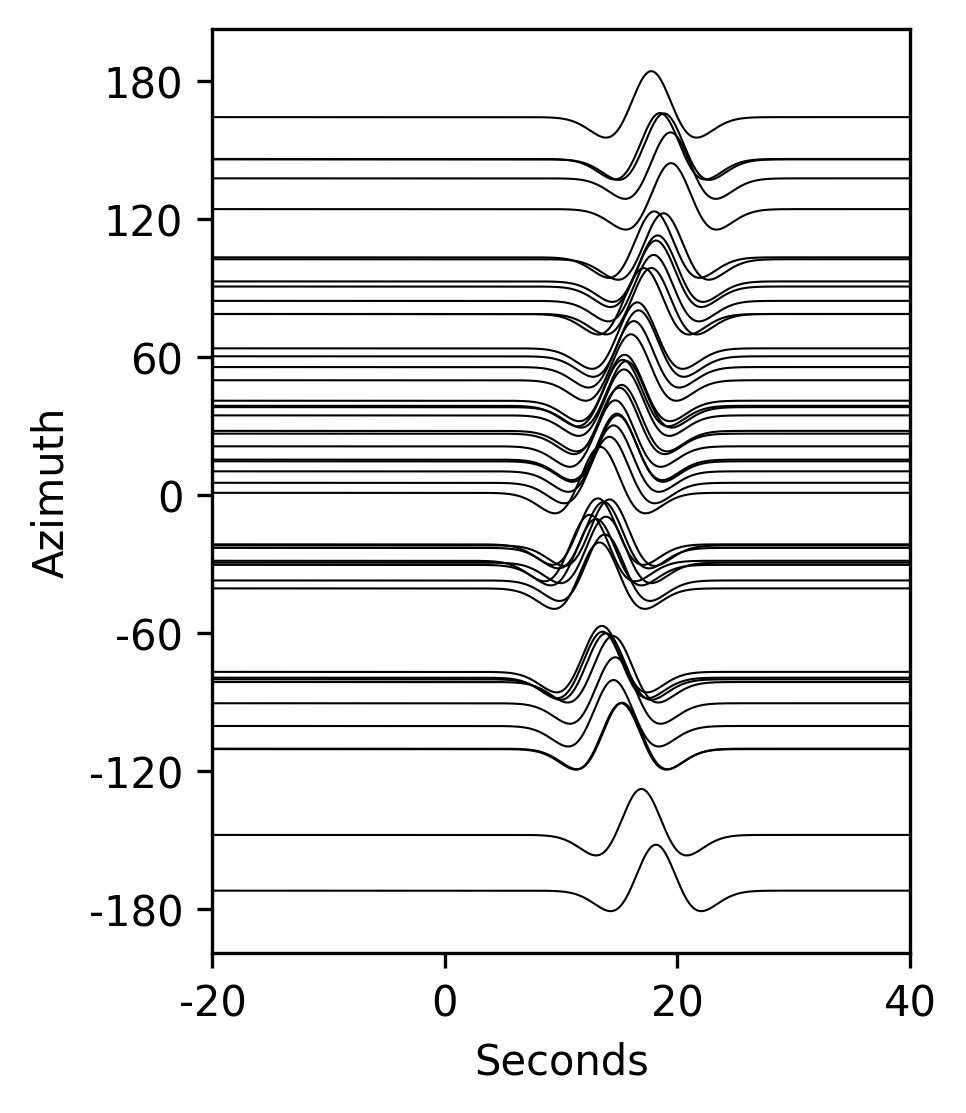

In [4]:
plt.figure(dpi=300,figsize=(3,4))

amplifier=20

for i in range(len(global_sensors)):
    tr=global_sensors[i].trace
    plt.plot(amplifier*tr+azimuths[i],lw=0.5,c='k')
    

plt.ylabel('Azimuth')
# plt.xticks([0,400,800,1200,1600,2000,2400],[-20,0,20,40,60,80,100])
plt.xticks([0,400,800,1200],[-20,0,20,40])
plt.xlabel('Seconds')
plt.xlim(0,1200)

plt.yticks([-180,-120,-60,0,60,120,180],[-180,-120,-60,0,60,120,180])

# DAS

In [5]:
mat=scipy.io.loadmat('/nfs/turbo/lsa-zspica/work/yaolinm/working_notebooks/mexico/my_bp_routine/posfib.mat')
channel_longs=mat['x0'][0]
channel_latis=mat['y0'][0]
selected_chs=np.load('/nfs/turbo/lsa-zspica/work/yaolinm/working_notebooks/mexico/my_bp_routine/egf1_s_selected_chs.npy')

das_latitudes,das_longitudes=[],[]
for i in range(0,len(selected_chs),20):
    das_latitudes.append(channel_latis[i])
    das_longitudes.append(channel_longs[i])

In [6]:
das_rtable=reference_table(model='iasp91',eq=eq,wave='P')       

corners=[[latitude_range[0],longitude_range[0]],[latitude_range[0],longitude_range[1]],[latitude_range[1],longitude_range[0]],[latitude_range[1],longitude_range[1]]]
degrees=[]
for corner in corners:
    for i in range(len(das_latitudes)):
        degrees.append(locations2degrees(das_latitudes[i],das_longitudes[i],corner[0],corner[1]))
        
das_rtable.cal_table(np.min(degrees)-0.1,np.max(degrees)+0.1,0.01)

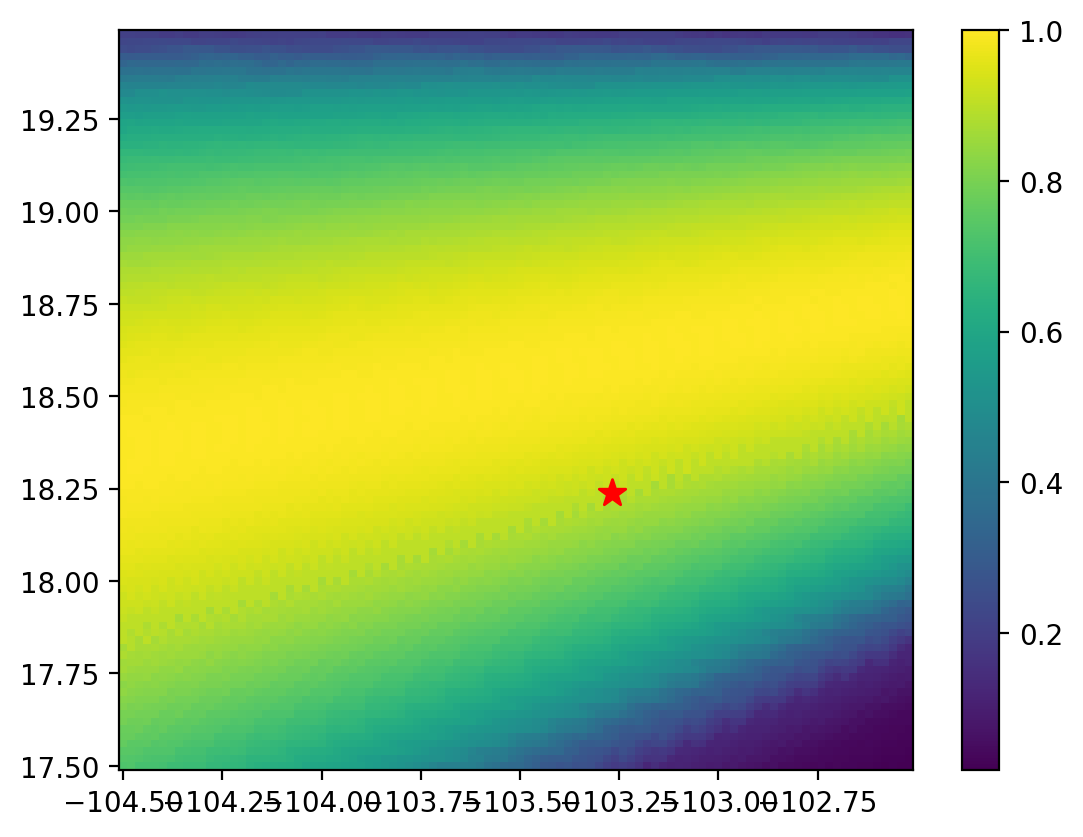

In [7]:
das_sensors=[]    
for i in range(len(das_latitudes)):
    das_sensor=sensor(das_longitudes[i],das_latitudes[i],trace_len=3000,sampling=50,eq_start=20)
    das_sensor.cal_epitime(eq,das_rtable)
    das_sensor.cal_epitime(sub1,das_rtable,etype='subevent')
#     das_sensor.cal_epitime(sub2,das_rtable,etype='subevent')
#     das_sensor.cal_epitime(sub3,das_rtable,etype='subevent')
    das_sensor.calculate_ttime(grid,das_rtable)
    tr=ricker_taup(60,das_sensor.sampling,1,1,20+1+das_sensor.subevents[0]-das_sensor.epitime)[0]
#     tr+=ricker_taup(120,das_sensor.sampling,0.1,0.8,20+8+das_sensor.subevents[1]-das_sensor.epitime)[0]
#     tr+=ricker_taup(120,das_sensor.sampling,0.1,0.6,20+20+das_sensor.subevents[2]-das_sensor.epitime)[0]
    das_sensor.trace=tr
    
    das_sensors.append(das_sensor)
    
bp_das=bp_bmfm(das_sensors,das_rtable,grid,eq)
bp_das.run_bp()
bp_das.plot_bp()

# Plots

In [18]:
import netCDF4 as nc
import cmocean
file='/home/yaolinm/Projects/Mexico2/data/gebco_2024_n21.0_s16.0_w-106.0_e-101.0.nc'
dataset = nc.Dataset(file, 'r')
variable = dataset.variables['elevation']
bmap = variable[:] 

from scipy.ndimage import zoom
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
resized_x_mesh=zoom(x_mesh,zoom=4,order=1)
resized_y_mesh=zoom(y_mesh,zoom=4,order=1)

colors = ['white', 'lightgray', 'gray', 'dimgray']
bounds = [-4000, 0, 1, 2, 4000]  # Define boundaries between colors
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

(17.5, 19.5)

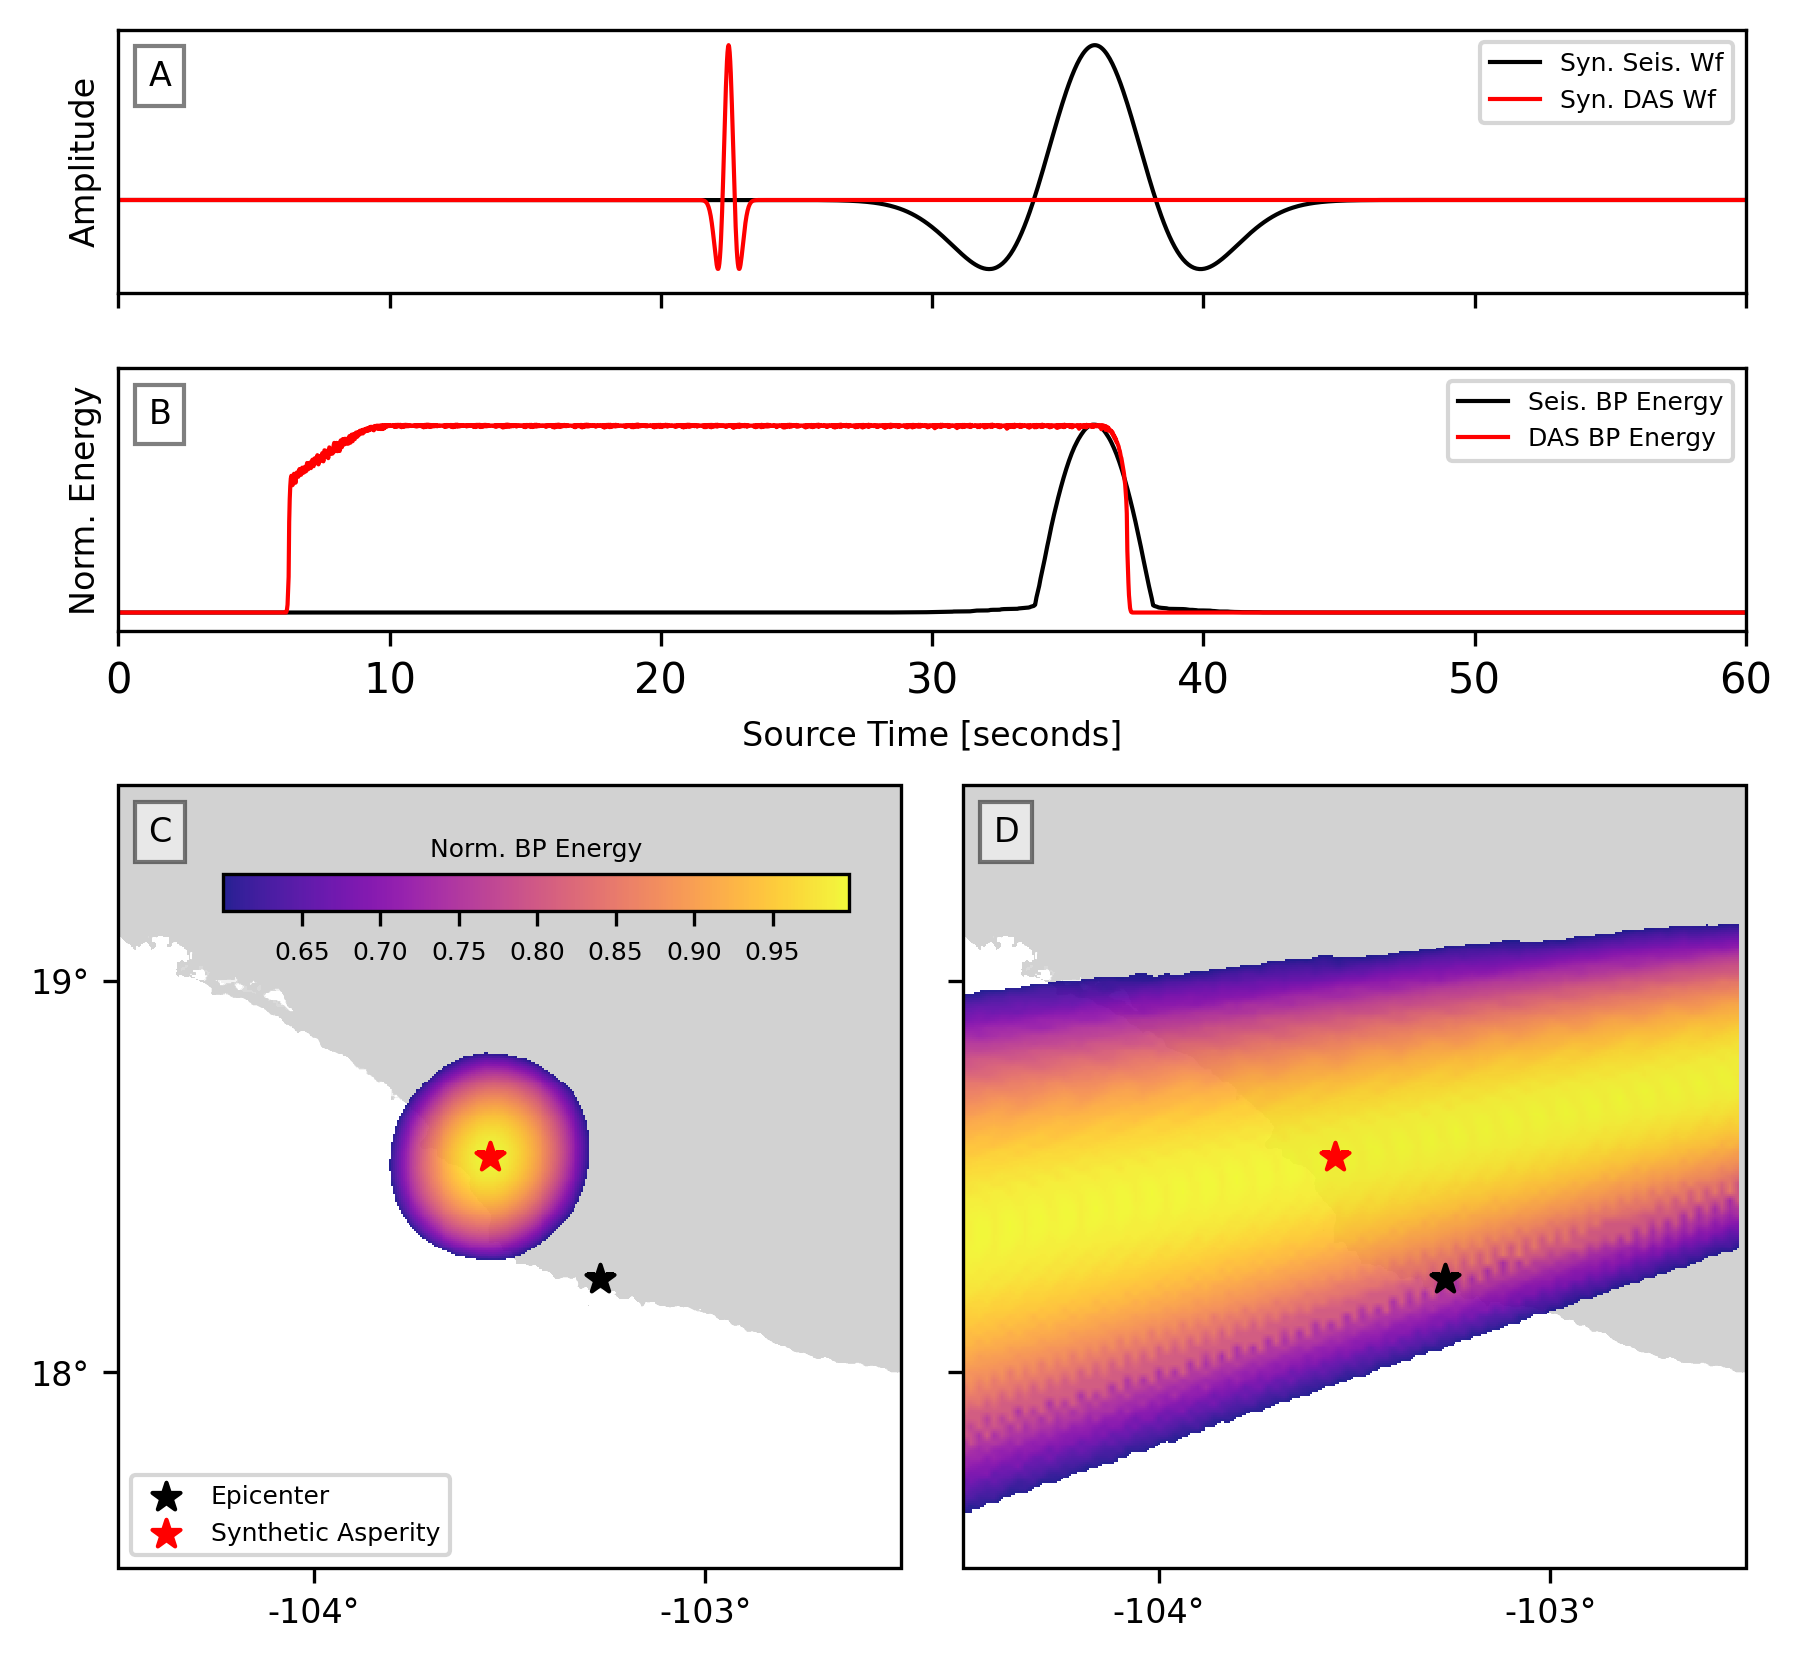

In [20]:
fig=plt.figure(dpi=300,figsize=(7,7))
fig.subplots_adjust(hspace=0.8,wspace=0.8)
proj=cartopy.crs.PlateCarree()

ax0 = plt.subplot2grid(shape=(10,12), loc=(0,0), colspan=12,rowspan=2)
ax1 = plt.subplot2grid(shape=(10,12), loc=(2,0), colspan=12,rowspan=2)
ax2 = plt.subplot2grid(shape=(10,12), loc=(4,0), colspan=6,rowspan=6, projection=proj)
ax3 = plt.subplot2grid(shape=(10,12), loc=(4,6), colspan=6,rowspan=6, projection=proj)


ax0.plot(ricker_taup(60,global_sensor.sampling,0.1,1,20+1)[1],
         ricker_taup(60,global_sensor.sampling,0.1,1,20+1)[0],c='k',lw=1,label='Syn. Seis. Wf')
ax0.plot(ricker_taup(60,das_sensor.sampling,1,1,20+1)[1],
         ricker_taup(60,das_sensor.sampling,1,1,20+1)[0],c='r',lw=1,label='Syn. DAS Wf')
ax0.set_xlim(0,60)
ax0.set_ylim(-0.6,1.1)
ax0.set_ylabel('Amplitude',fontsize=8)
ax0.set_yticks([])
ax0.set_xticks([0,10,20,30,40,50,60])
ax0.set_xticklabels(['','','','','','',''])
# ax0.xaxis.tick_top()
# ax0.xaxis.set_label_position('top')

ax1.plot(ricker_taup(60,global_sensor.sampling,0.1,1,20+1)[1],
         np.max(bp_global.master,axis=(0,1))[:],c='k',lw=1,label='Seis. BP Energy')
ax1.plot(ricker_taup(60,das_sensor.sampling,1,1,20+1)[1],
         np.max(bp_das.master,axis=(0,1))[:],c='r',lw=1,label='DAS BP Energy')
ax1.set_xlim(0,60)
ax1.set_ylim(-0.1,1.3)
ax1.set_ylabel('Norm. Energy',fontsize=8)
ax1.set_yticks([])
ax1.set_xlabel('Source Time [seconds]',fontsize=8)


bs=ax2.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
resized_data=zoom(np.max(bp_global.master,axis=-1).T,zoom=4,order=1)
z=np.ma.masked_array(resized_data,resized_data<0.6)
pc=ax2.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9)
ax2.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
ax2.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

ax3.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
              alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
resized_data=zoom(np.max(bp_das.master,axis=-1).T,zoom=4,order=1)
z=np.ma.masked_array(resized_data,resized_data<0.8)
ax3.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9)
ax3.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
ax3.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

ax0.legend(loc='upper right', fontsize=6, frameon=True)
ax1.legend(loc='upper right', fontsize=6, frameon=True)
ax2.legend(loc='lower left', fontsize=6, frameon=True)

cax1 = fig.add_axes([ax2.get_position().x0+0.05, ax2.get_position().y1 - 0.06, 
                           ax3.get_position().width*0.8, 0.018])
cbar1 = plt.colorbar(pc, cax=cax1, orientation='horizontal')
cbar1.set_label('Norm. BP Energy', fontsize=6)
cbar1.ax.tick_params(labelsize=6)
cbar1.ax.xaxis.set_label_position("top")

# ax0.text(0.01, 0.96, 'A Synthetic waveforms', transform=ax0.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='left', 
#         bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
# ax1.text(0.01, 0.96, 'B Normalized BP energy', transform=ax1.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='left', 
#         bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
# ax2.text(0.03, 0.96, 'C Synthetic seismometer BP', transform=ax2.transAxes, fontsize=8,verticalalignment='top', horizontalalignment='left', 
#         bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
# ax3.text(0.03, 0.96, 'D Synthetic DAS BP', transform=ax3.transAxes, fontsize=8,verticalalignment='top', horizontalalignment='left', 
#         bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))

at = AnchoredText('A',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax0.add_artist(at)

at = AnchoredText('B',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax1.add_artist(at)

at = AnchoredText('C',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax2.add_artist(at)

at = AnchoredText('D',prop=dict(size=8), frameon=True,loc=2)
at.patch.set_boxstyle('round',pad=0,rounding_size=0)
at.patch.set_facecolor((1, 1, 1, 0.5))  
at.patch.set_edgecolor((0, 0, 0, 0.5))
ax3.add_artist(at)

ax2.set_xticks([-104, -103])
ax2.set_xticklabels( [f"{x}°" for x in [ -104, -103]], fontsize=8)
ax2.set_yticks([18, 19])
ax2.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
ax2.set_xlim(-104.5,-102.5)
ax2.set_ylim(17.5,19.5)

ax3.set_xticks([-104, -103])
ax3.set_xticklabels( [f"{x}°" for x in [ -104, -103]], fontsize=8)
ax3.set_yticks([18, 19])
ax3.set_yticklabels(['',''], fontsize=8)
ax3.set_xlim(-104.5,-102.5)
ax3.set_ylim(17.5,19.5)

In [25]:
for index in range(50):
    
    fig=plt.figure(dpi=200,figsize=(7,7))
    fig.subplots_adjust(hspace=0.6,wspace=0.6)
    proj=cartopy.crs.PlateCarree()

    ax0 = plt.subplot2grid(shape=(10,12), loc=(0,0), colspan=12,rowspan=2)
    ax1 = plt.subplot2grid(shape=(10,12), loc=(2,0), colspan=12,rowspan=2)
    ax2 = plt.subplot2grid(shape=(10,12), loc=(4,0), colspan=6,rowspan=6, projection=proj)
    ax3 = plt.subplot2grid(shape=(10,12), loc=(4,6), colspan=6,rowspan=6, projection=proj)


    ax0.plot(ricker_taup(60,global_sensor.sampling,0.1,1,20+1)[1],
             ricker_taup(60,global_sensor.sampling,0.1,1,20+1)[0],c='k',lw=1,label='Syn. Seis. Wf')
    ax0.plot(ricker_taup(60,das_sensor.sampling,1,1,20+1)[1],
             ricker_taup(60,das_sensor.sampling,1,1,20+1)[0],c='r',lw=1,label='Syn. DAS Wf')
    ax0.set_xlim(0,60)
    ax0.set_ylim(-0.6,1.1)
    ax0.set_ylabel('Amplitude',fontsize=8)
    ax0.set_yticks([])
    ax0.set_xlabel('Source Time [seconds]',fontsize=8)
    ax0.xaxis.tick_top()
    ax0.xaxis.set_label_position('top')


    ax1.plot(ricker_taup(60,global_sensor.sampling,0.1,1,20+1)[1],
             np.max(bp_global.master,axis=(0,1))[:],c='k',lw=1,label='Seis. BP Energy')
    ax1.plot(ricker_taup(60,das_sensor.sampling,1,1,20+1)[1],
             np.max(bp_das.master,axis=(0,1))[:],c='r',lw=1,label='DAS BP Energy')
    ax1.set_xlim(0,60)
    ax1.set_ylim(-0.1,1.3)
    ax1.set_ylabel('Norm. Energy',fontsize=8)
    ax1.set_yticks([])
    ax1.set_xticks([0,10,20,30,40,50,60])
    ax1.set_xticklabels(['','','','','','',''])

    bs=ax2.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
                  alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
    
    data=fetch_sliced_image(bp_global.master,index,5,time_window=5,temporal_averageing=5,sampling_rate=20,
                            normalize=False,taper='hamming')
    data=np.max(data,axis=-1)
    resized_data=zoom(data.T,zoom=4,order=1)
    z=np.ma.masked_array(resized_data,resized_data<0.4)
    if index==0:
        pc=ax2.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9,vmin=0.4,vmax=1)
    else:
        ax2.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9,vmin=0.4,vmax=1)
    
    ax2.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
    ax2.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

    ax3.imshow(np.flipud(bmap[240:960,240:960]),cmap=cmap,norm=norm,
                  alpha=0.3,extent=[-105.02,-102,16.98,20],transform=proj)
    data=fetch_sliced_image(bp_das.master,index,5,time_window=5,temporal_averageing=5,sampling_rate=50,
                            normalize=False,taper='hamming')
    data=np.max(data,axis=-1)
    resized_data=zoom(data.T,zoom=4,order=1)
    z=np.ma.masked_array(resized_data,resized_data<0.5)
    ax3.pcolormesh(resized_x_mesh,resized_y_mesh,z,cmap='plasma',alpha=0.9,vmin=0.4,vmax=1)
    ax3.scatter(eq.longitude,eq.latitude,marker='*',c='k',s=50,label='Epicenter')
    ax3.scatter(sub1.longitude,sub1.latitude,marker='*',c='r',s=50,label='Synthetic Asperity')

    ax0.legend(loc='upper right', fontsize=6, frameon=True)
    ax1.legend(loc='upper right', fontsize=6, frameon=True)
    ax2.legend(loc='lower left', fontsize=6, frameon=True)

    cax1 = fig.add_axes([ax2.get_position().x0+0.05, ax2.get_position().y1 - 0.07, 
                               ax2.get_position().width*0.8, 0.018])
    cbar1 = plt.colorbar(pc, cax=cax1, orientation='horizontal')
    cbar1.set_label('Norm. BP Energy', fontsize=6)
    cbar1.ax.tick_params(labelsize=6)
    cbar1.ax.xaxis.set_label_position("top")
    cbar1.set_ticks([0.4,0.6,0.8,1])


    ax0.text(0.01, 0.96, '[A] Synthetic waveforms', transform=ax0.transAxes, fontsize=6, verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
    ax1.text(0.01, 0.96, '[B] Normalized BP energy', transform=ax1.transAxes, fontsize=6, verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
    ax2.text(0.03, 0.96, '[C] Synthetic seismometer BP', transform=ax2.transAxes, fontsize=6,verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
    ax3.text(0.03, 0.96, '[D] Synthetic DAS BP', transform=ax3.transAxes, fontsize=6,verticalalignment='top', horizontalalignment='left', 
            bbox=dict(facecolor='white',edgecolor='grey',alpha=0.8,pad=1))
    
    starting_time=max(int(5+index-5/2),0)
    ending_time=min(starting_time+5,60)
    rect = patches.Rectangle((starting_time,-0.55), ending_time-starting_time, 1.6, linewidth=1, edgecolor='r', facecolor='r',alpha=0.15)
    ax0.add_patch(rect)
    
    rect = patches.Rectangle((starting_time,-0.05), ending_time-starting_time, 1.3, linewidth=1, edgecolor='r', facecolor='r',alpha=0.15)
    ax1.add_patch(rect)
    
    ax2.set_xticks([-104, -103])
    ax2.set_xticklabels( [f"{x}°" for x in [ -104, -103]], fontsize=8)
    ax2.set_yticks([18, 19])
    ax2.set_yticklabels([f"{y}°" for y in [18, 19]], fontsize=8)
    ax2.set_xlim(-104.5,-102.5)
    ax2.set_ylim(17.5,19.5)

    ax3.set_xticks([-104, -103])
    ax3.set_xticklabels( [f"{x}°" for x in [ -104, -103]], fontsize=8)
    ax3.set_yticks([18, 19])
    ax3.set_yticklabels(['',''], fontsize=8)
    ax3.set_xlim(-104.5,-102.5)
    ax3.set_ylim(17.5,19.5)
    
    fig.suptitle('Time: {} seconds'.format(str(5+index)))
    plt.savefig('figures/swimming/{}.png'.format(str(index).zfill(2)))
    plt.close()

In [26]:
import cv2
import os

image_folder = 'figures/swimming'
output_video = "figures/swimming.mp4"
fps = 10 

# Get image list and sort them
images = sorted([img for img in os.listdir(image_folder) if img.endswith(".png")])  # Adjust extension if needed

# Read the first image to get dimensions
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter
fourcc = cv2.VideoWriter_fourcc(*"mp4v") 
video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Add images to the video
for image in images:
    img = cv2.imread(os.path.join(image_folder, image))
    video.write(img)

video.release()
cv2.destroyAllWindows()